In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
from nltk.corpus import stopwords
from tensorflow.python.framework import ops

import sys
sys.path.append(os.getcwd() + '/Chapter07')
import text_helpers

import pandas as pd


/home/admin-/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
ops.reset_default_graph()
# os.chdir(os.path.dirname(os.path.realpath(__file__)))

NameError: name '__file__' is not defined

In [52]:
data_folder_name = os.getcwd() + '/Chapter07/temp/'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [5]:
# Start a graph session
sess = tf.Session()

# Declare model parameters
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # Word embedding size
doc_embedding_size = 100   # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # Number of negative examples to sample.
window_size = 3       # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

In [12]:
# df = pd.read_csv('./temp/df_180807.tsv', sep='\t')

In [51]:
# # Load the movie review data
# print('Loading Data')
# texts, target = text_helpers.load_movie_data(data_folder_name)

Loading Data


EOFError: Compressed file ended before the end-of-stream marker was reached

In [56]:
pos_data = []
with open('/home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/temp/rt-polaritydata/rt-polarity.pos', 'r'
        , encoding = 'latin-1') as temp_pos_file:
    for row in temp_pos_file:
        pos_data.append(row)

neg_data = []
with open('/home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/temp/rt-polaritydata/rt-polarity.neg', 'r'
        , encoding = 'latin-1') as temp_neg_file:
    for row in temp_neg_file:
        neg_data.append(row)
        
texts = pos_data + neg_data
target = [1]*len(pos_data) + [0]*len(neg_data)

In [64]:
# Declare stop words
stops = stopwords.words('english')

# We pick a few test words for validation.
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]    
assert(len(target)==len(texts))

Normalizing Text Data


In [66]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]    

Creating Dictionary


In [67]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))
# assert(len(target)==len(texts))

Creating Model


In [68]:
# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [69]:
# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [82]:
# Lookup the word embedding
# Add together element embeddings in window:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

# x_inputs                     =>  doc_indices
# word, word, word  doc_id      doc_id
# word, word, word  doc_id      doc_id
# word, word, word  doc_id  =>  doc_id
# word, word, word  doc_id      doc_id
# word, word, word  doc_id      doc_id
doc_indices = tf.slice(input_=x_inputs, begin=[0, window_size], size=[batch_size, 1])

doc_embed = tf.nn.embedding_lookup(doc_embeddings, doc_indices)

# concatenate embeddings
final_embed = tf.concat([embed, tf.squeeze(doc_embed)], 1)
# word_emb, word_emb, word_emb, doc_emb
# word_emb, word_emb, word_emb, doc_emb
# word_emb, word_emb, word_emb, doc_emb
# word_emb, word_emb, word_emb, doc_emb
# word_emb, word_emb, word_emb, doc_emb

In [77]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, y_target, final_embed,
                                     num_sampled = num_sampled, num_classes = vocabulary_size))

# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

In [79]:
# Cosine similarity between words
# cosine similarity 를 이용하여 valid dataset의 similarity 구함
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [80]:
# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [162]:
batch_data = []
label_data = []
sentences = text_data



while len(batch_data) < batch_size:
    rand_sentence_ix = int(np.random.choice(len(sentences), size=1))
    rand_sentence = sentences[rand_sentence_ix]
# rand_sentence = [59, 142, 2838, 0, 155, 222, 46, 171, 7335, 5]
    # window_sequences = [rand_sentence[max((idx-window_size),0):(idx+window_size+1)] for idx, x in enumerate(rand_sentence)]
    # window_sequences = [[59, 142, 2838, 0], [59, 142, 2838, 0, 155], [59, 142, 2838, 0, 155, 222], [59, 142, 2838, 0, 155, 222, 46], [142, 2838, 0, 155, 222, 46, 171], [2838, 0, 155, 222, 46, 171, 7335], [0, 155, 222, 46, 171, 7335, 5], [155, 222, 46, 171, 7335, 5], [222, 46, 171, 7335, 5], [46, 171, 7335, 5]]
    # label_indices = [ix if ix<window_size else window_size for ix,x in enumerate(window_sequences)]
    # method=='doc2vec':
    # For doc2vec we keep LHS window only to predict target word
    # batch_and_labels = [([59, 142, 2838], 0), ([142, 2838, 0], 155), ([2838, 0, 155], 222), ([0, 155, 222], 46), ([155, 222, 46], 171), ([222, 46, 171], 7335), ([46, 171, 7335], 5)]
    batch_and_labels = [(rand_sentence[i:i+window_size], rand_sentence[i+window_size]) for i in range(0, len(rand_sentence)-window_size)]
    batch, labels = [list(x) for x in zip(*batch_and_labels)]
    batch = [x + [rand_sentence_ix] for x in batch]
    
    # Add document index to batch!! Remember that we must extract the last index in batch for the doc-index
    batch_data.extend(batch[:batch_size])
    label_data.extend(labels[:batch_size])


In [67]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))
# assert(len(target)==len(texts))

Creating Model


In [163]:

batch_data = batch_data[:batch_size]
label_data = label_data[:batch_size]

# Convert to numpy array
batch_data = np.array(batch_data)
label_data = np.transpose(np.array([label_data]))


In [169]:
label_data

array([[ 755],
       [1132],
       [2572],
       [   3],
       [  60],
       [ 364],
       [  55],
       [   2],
       [7033],
       [ 364],
       [ 631],
       [ 198],
       [   0],
       [4701],
       [   0],
       [2443],
       [ 961],
       [  13],
       [1072],
       [  28],
       [   0],
       [1833],
       [  51],
       [  75],
       [  33],
       [1247],
       [ 630],
       [2904],
       [ 467],
       [5796],
       [  23],
       [2561],
       [ 422],
       [   3],
       [ 340],
       [   0],
       [  22],
       [  83],
       [1239],
       [2328],
       [ 419],
       [1940],
       [ 206],
       [ 783],
       [1885],
       [   0],
       [2659],
       [  74],
       [5239],
       [  41],
       [   0],
       [   2],
       [   4],
       [ 640],
       [4892],
       [4095],
       [  51],
       [4285],
       [5212],
       [ 168],
       [   0],
       [ 819],
       [2456],
       [ 192],
       [   6],
       [3141],
       [  

In [150]:

batch_data = batch_data[:batch_size]
label_data = label_data[:batch_size]

In [138]:
batch = [x + [rand_sentence_ix] for x in batch]

In [151]:
batch_data

[[721, 579, 110, 3214],
 [579, 110, 4793, 3214],
 [110, 4793, 39, 3214],
 [4793, 39, 2, 3214],
 [39, 2, 969, 3214],
 [2, 969, 369, 3214],
 [969, 369, 25, 3214],
 [369, 25, 264, 3214],
 [25, 264, 190, 3214],
 [264, 190, 17, 3214],
 [190, 17, 298, 3214],
 [721, 579, 110, 3214],
 [579, 110, 4793, 3214],
 [110, 4793, 39, 3214],
 [4793, 39, 2, 3214],
 [39, 2, 969, 3214],
 [2, 969, 369, 3214],
 [969, 369, 25, 3214],
 [369, 25, 264, 3214],
 [25, 264, 190, 3214],
 [264, 190, 17, 3214],
 [190, 17, 298, 3214],
 [721, 579, 110, 3214],
 [579, 110, 4793, 3214],
 [110, 4793, 39, 3214],
 [4793, 39, 2, 3214],
 [39, 2, 969, 3214],
 [2, 969, 369, 3214],
 [969, 369, 25, 3214],
 [369, 25, 264, 3214],
 [25, 264, 190, 3214],
 [264, 190, 17, 3214],
 [190, 17, 298, 3214],
 [721, 579, 110, 3214],
 [579, 110, 4793, 3214],
 [110, 4793, 39, 3214],
 [4793, 39, 2, 3214],
 [39, 2, 969, 3214],
 [2, 969, 369, 3214],
 [969, 369, 25, 3214],
 [369, 25, 264, 3214],
 [25, 264, 190, 3214],
 [264, 190, 17, 3214],
 [190, 17, 

In [144]:
batch_data.

array([[  59,  142, 2838,  757],
       [ 142, 2838,    0,  757],
       [2838,    0,  155,  757],
       ...,
       [  59,  142, 2838,  757],
       [ 142, 2838,    0,  757],
       [2838,    0,  155,  757]])

In [81]:
# Run the skip gram model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(
        text_data, batch_size, window_size, method='doc2vec')
    
    '''
        x = [['i', 'am', 2],
         ['am', 'sorry', 2],
         ['sorry', 'but', 2],
         ['but', 'i', 2],
         ['i', 'love', 2],
         ['love', 'you', 2],
         ['you', '다', 2]]
        // 여기서 2는 doc_id

        y = ['sorry', 'but', 'i', 'love', 'you']
    '''

    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training


Loss at step 100 : 628.464599609375


Loss at step 200 : 636.0618896484375


Loss at step 300 : 597.6636962890625


Loss at step 400 : 620.3699951171875


Loss at step 500 : 540.2425537109375


Loss at step 600 : 559.2030029296875


Loss at step 700 : 579.6428833007812


Loss at step 800 : 517.1127319335938


Loss at step 900 : 543.0765380859375


Loss at step 1000 : 501.2564392089844


Loss at step 1100 : 459.6858825683594


Loss at step 1200 : 495.25726318359375


Loss at step 1300 : 526.5216064453125


Loss at step 1400 : 514.8302001953125


Loss at step 1500 : 548.2741088867188


Loss at step 1600 : 497.1196594238281


Loss at step 1700 : 448.8726806640625


Loss at step 1800 : 460.0523376464844


Loss at step 1900 : 463.58917236328125


Loss at step 2000 : 443.3204040527344


Loss at step 2100 : 456.5766906738281


Loss at step 2200 : 412.375


Loss at step 2300 : 413.76800537109375


Loss at step 2400 : 423.2757263183594


Loss at step 2500 : 402.85107421875


Loss at step 2600 : 437.022216796875


Loss at step 2700 : 401.4002990722656


Loss at step 2800 : 434.47454833984375


Loss at step 2900 : 434.8593444824219


Loss at step 3000 : 400.12396240234375


Loss at step 3100 : 405.4183654785156


Loss at step 3200 : 354.5293273925781


Loss at step 3300 : 407.13201904296875


Loss at step 3400 : 370.84429931640625


Loss at step 3500 : 384.7926330566406


Loss at step 3600 : 356.2498779296875


Loss at step 3700 : 396.0796203613281


Loss at step 3800 : 362.3740539550781


Loss at step 3900 : 367.8581848144531


Loss at step 4000 : 353.00335693359375


Loss at step 4100 : 362.39697265625


Loss at step 4200 : 336.4878234863281


Loss at step 4300 : 333.5133056640625


Loss at step 4400 : 354.57293701171875


Loss at step 4500 : 319.1820373535156


Loss at step 4600 : 334.47955322265625


Loss at step 4700 : 331.5833740234375


Loss at step 4800 : 330.1589660644531


Loss at step 4900 : 328.5409240722656


Loss at step 5000 : 322.38055419921875
Nearest to love: forget, description, tunney, brainless, dire,
Nearest to hate: title, motions, transformed, cliché, avalanche,
Nearest to happy: comically, rabbitproof, derives, failure, weird,
Nearest to sad: clothes, estrogen, underestimated, viveka, nonthreatening,
Nearest to man: displaying, thousands, tattered, groundbreaking, nicole,
Nearest to woman: mopping, part, rather, old, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 5100 : 343.4982604980469


Loss at step 5200 : 331.7381286621094


Loss at step 5300 : 339.3468933105469


Loss at step 5400 : 306.4158630371094


Loss at step 5500 : 332.0115661621094


Loss at step 5600 : 308.5601806640625


Loss at step 5700 : 344.1044921875


Loss at step 5800 : 290.5260009765625


Loss at step 5900 : 310.0504455566406


Loss at step 6000 : 296.4939880371094


Loss at step 6100 : 292.824951171875


Loss at step 6200 : 321.4782409667969


Loss at step 6300 : 301.31268310546875


Loss at step 6400 : 301.5829162597656


Loss at step 6500 : 284.0710754394531


Loss at step 6600 : 314.1914367675781


Loss at step 6700 : 280.7607116699219


Loss at step 6800 : 241.5409393310547


Loss at step 6900 : 325.3104248046875


Loss at step 7000 : 286.5858154296875


Loss at step 7100 : 250.9484405517578


Loss at step 7200 : 247.42613220214844


Loss at step 7300 : 233.8578338623047


Loss at step 7400 : 265.4263610839844


Loss at step 7500 : 295.14605712890625


Loss at step 7600 : 273.1475524902344


Loss at step 7700 : 289.41900634765625


Loss at step 7800 : 252.2401580810547


Loss at step 7900 : 281.12249755859375


Loss at step 8000 : 252.943359375


Loss at step 8100 : 254.8169708251953


Loss at step 8200 : 255.0115966796875


Loss at step 8300 : 200.64793395996094


Loss at step 8400 : 278.91015625


Loss at step 8500 : 277.9523620605469


Loss at step 8600 : 256.1515808105469


Loss at step 8700 : 262.7819519042969


Loss at step 8800 : 268.9782409667969


Loss at step 8900 : 267.5743408203125


Loss at step 9000 : 272.08319091796875


Loss at step 9100 : 233.98269653320312


Loss at step 9200 : 249.74514770507812


Loss at step 9300 : 258.5440979003906


Loss at step 9400 : 243.7466583251953


Loss at step 9500 : 213.29258728027344


Loss at step 9600 : 253.76669311523438


Loss at step 9700 : 219.75958251953125


Loss at step 9800 : 243.5161590576172


Loss at step 9900 : 213.06521606445312


Loss at step 10000 : 217.2689971923828
Nearest to love: forget, description, tunney, showdown, amusing,
Nearest to hate: title, motions, transformed, cliché, avalanche,
Nearest to happy: comically, rabbitproof, derives, craig, fans,
Nearest to sad: clothes, estrogen, underestimated, nonthreatening, match,
Nearest to man: displaying, tattered, thousands, nicole, groundbreaking,
Nearest to woman: mopping, part, rather, old, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 10100 : 254.18649291992188


Loss at step 10200 : 244.3531494140625


Loss at step 10300 : 227.81527709960938


Loss at step 10400 : 245.8350067138672


Loss at step 10500 : 250.6411895751953


Loss at step 10600 : 217.8228759765625


Loss at step 10700 : 207.69155883789062


Loss at step 10800 : 208.3489227294922


Loss at step 10900 : 225.92727661132812


Loss at step 11000 : 208.95684814453125


Loss at step 11100 : 219.74388122558594


Loss at step 11200 : 237.7339630126953


Loss at step 11300 : 184.4294891357422


Loss at step 11400 : 212.80703735351562


Loss at step 11500 : 231.4120330810547


Loss at step 11600 : 195.41778564453125


Loss at step 11700 : 207.54464721679688


Loss at step 11800 : 174.81903076171875


Loss at step 11900 : 186.26902770996094


Loss at step 12000 : 180.8069305419922


Loss at step 12100 : 201.68568420410156


Loss at step 12200 : 232.22134399414062


Loss at step 12300 : 175.72084045410156


Loss at step 12400 : 209.17843627929688


Loss at step 12500 : 172.79771423339844


Loss at step 12600 : 197.3273162841797


Loss at step 12700 : 172.04052734375


Loss at step 12800 : 186.92303466796875


Loss at step 12900 : 154.44290161132812


Loss at step 13000 : 202.25608825683594


Loss at step 13100 : 192.99172973632812


Loss at step 13200 : 185.81661987304688


Loss at step 13300 : 183.77426147460938


Loss at step 13400 : 197.1205291748047


Loss at step 13500 : 183.49757385253906


Loss at step 13600 : 163.53167724609375


Loss at step 13700 : 164.72535705566406


Loss at step 13800 : 187.3488311767578


Loss at step 13900 : 170.82948303222656


Loss at step 14000 : 177.05441284179688


Loss at step 14100 : 179.12677001953125


Loss at step 14200 : 167.47769165039062


Loss at step 14300 : 185.6555633544922


Loss at step 14400 : 149.68710327148438


Loss at step 14500 : 175.5934600830078


Loss at step 14600 : 153.7469482421875


Loss at step 14700 : 168.98468017578125


Loss at step 14800 : 141.44480895996094


Loss at step 14900 : 152.24887084960938


Loss at step 15000 : 189.54969787597656
Nearest to love: RARE, film, forget, amusing, tunney,
Nearest to hate: title, motions, transformed, cliché, scene,
Nearest to happy: comically, rabbitproof, derives, fans, craig,
Nearest to sad: clothes, estrogen, underestimated, nonthreatening, match,
Nearest to man: displaying, tattered, thousands, penetrating, nature,
Nearest to woman: mopping, part, rather, old, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 15100 : 177.05377197265625


Loss at step 15200 : 169.88075256347656


Loss at step 15300 : 173.31393432617188


Loss at step 15400 : 196.9027557373047


Loss at step 15500 : 157.96798706054688


Loss at step 15600 : 181.78750610351562


Loss at step 15700 : 173.39910888671875


Loss at step 15800 : 159.9265899658203


Loss at step 15900 : 161.505126953125


Loss at step 16000 : 184.7455596923828


Loss at step 16100 : 136.16140747070312


Loss at step 16200 : 149.746337890625


Loss at step 16300 : 152.84178161621094


Loss at step 16400 : 144.32571411132812


Loss at step 16500 : 154.93809509277344


Loss at step 16600 : 189.93576049804688


Loss at step 16700 : 149.74656677246094


Loss at step 16800 : 145.81756591796875


Loss at step 16900 : 140.8432159423828


Loss at step 17000 : 156.0460662841797


Loss at step 17100 : 129.29507446289062


Loss at step 17200 : 155.56776428222656


Loss at step 17300 : 134.3775634765625


Loss at step 17400 : 144.7186279296875


Loss at step 17500 : 160.2769317626953


Loss at step 17600 : 144.099853515625


Loss at step 17700 : 157.66070556640625


Loss at step 17800 : 145.05104064941406


Loss at step 17900 : 178.1148223876953


Loss at step 18000 : 140.39015197753906


Loss at step 18100 : 115.10545349121094


Loss at step 18200 : 155.25169372558594


Loss at step 18300 : 128.54156494140625


Loss at step 18400 : 139.80213928222656


Loss at step 18500 : 159.45318603515625


Loss at step 18600 : 140.77658081054688


Loss at step 18700 : 148.84774780273438


Loss at step 18800 : 104.38582611083984


Loss at step 18900 : 132.78543090820312


Loss at step 19000 : 133.06509399414062


Loss at step 19100 : 141.35928344726562


Loss at step 19200 : 131.83201599121094


Loss at step 19300 : 133.81576538085938


Loss at step 19400 : 124.96187591552734


Loss at step 19500 : 152.98765563964844


Loss at step 19600 : 124.34127807617188


Loss at step 19700 : 142.94821166992188


Loss at step 19800 : 124.91018676757812


Loss at step 19900 : 124.85443878173828


Loss at step 20000 : 158.86346435546875
Nearest to love: RARE, film, forget, like, story,
Nearest to hate: title, motions, transformed, cliché, scene,
Nearest to happy: comically, rabbitproof, derives, fans, craig,
Nearest to sad: clothes, estrogen, underestimated, performances, match,
Nearest to man: displaying, tattered, nature, penetrating, thousands,
Nearest to woman: part, mopping, rather, old, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 20100 : 130.78152465820312


Loss at step 20200 : 112.71733093261719


Loss at step 20300 : 119.89102935791016


Loss at step 20400 : 124.56776428222656


Loss at step 20500 : 124.5888671875


Loss at step 20600 : 98.18701934814453


Loss at step 20700 : 124.46734619140625


Loss at step 20800 : 123.73479461669922


Loss at step 20900 : 132.45298767089844


Loss at step 21000 : 128.48641967773438


Loss at step 21100 : 116.12315368652344


Loss at step 21200 : 130.3195037841797


Loss at step 21300 : 110.5950698852539


Loss at step 21400 : 122.56068420410156


Loss at step 21500 : 134.90341186523438


Loss at step 21600 : 113.03409576416016


Loss at step 21700 : 115.14320373535156


Loss at step 21800 : 123.22954559326172


Loss at step 21900 : 104.04108428955078


Loss at step 22000 : 99.90912628173828


Loss at step 22100 : 108.3569564819336


Loss at step 22200 : 129.7957763671875


Loss at step 22300 : 104.19445037841797


Loss at step 22400 : 126.40975952148438


Loss at step 22500 : 102.25066375732422


Loss at step 22600 : 109.38593292236328


Loss at step 22700 : 122.40226745605469


Loss at step 22800 : 100.41870880126953


Loss at step 22900 : 141.4704132080078


Loss at step 23000 : 114.3307876586914


Loss at step 23100 : 96.2967529296875


Loss at step 23200 : 103.65885162353516


Loss at step 23300 : 126.048095703125


Loss at step 23400 : 100.98416137695312


Loss at step 23500 : 114.50312805175781


Loss at step 23600 : 109.9110336303711


Loss at step 23700 : 126.57734680175781


Loss at step 23800 : 110.8818588256836


Loss at step 23900 : 100.97348022460938


Loss at step 24000 : 116.30828094482422


Loss at step 24100 : 111.1719970703125


Loss at step 24200 : 89.21208190917969


Loss at step 24300 : 100.21153259277344


Loss at step 24400 : 102.12458801269531


Loss at step 24500 : 115.54436492919922


Loss at step 24600 : 88.57794952392578


Loss at step 24700 : 100.83885955810547


Loss at step 24800 : 82.06893157958984


Loss at step 24900 : 101.99678802490234


Loss at step 25000 : 92.41309356689453
Nearest to love: RARE, film, like, story, forget,
Nearest to hate: title, transformed, motions, scene, cliché,
Nearest to happy: comically, rabbitproof, derives, fans, craig,
Nearest to sad: clothes, estrogen, performances, underestimated, match,
Nearest to man: displaying, tattered, nature, director, trying,
Nearest to woman: part, rather, mopping, old, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 25100 : 104.9809341430664


Loss at step 25200 : 104.90501403808594


Loss at step 25300 : 108.64646911621094


Loss at step 25400 : 105.76583099365234


Loss at step 25500 : 89.82581329345703


Loss at step 25600 : 103.01800537109375


Loss at step 25700 : 90.14525604248047


Loss at step 25800 : 96.89045715332031


Loss at step 25900 : 100.02142333984375


Loss at step 26000 : 107.33386993408203


Loss at step 26100 : 100.21453857421875


Loss at step 26200 : 86.7209243774414


Loss at step 26300 : 84.14897155761719


Loss at step 26400 : 88.57295989990234


Loss at step 26500 : 97.72887420654297


Loss at step 26600 : 77.43020629882812


Loss at step 26700 : 114.18070220947266


Loss at step 26800 : 78.54039764404297


Loss at step 26900 : 111.30198669433594


Loss at step 27000 : 77.13349151611328


Loss at step 27100 : 84.27401733398438


Loss at step 27200 : 84.54553985595703


Loss at step 27300 : 106.50244903564453


Loss at step 27400 : 83.88773345947266


Loss at step 27500 : 85.87987518310547


Loss at step 27600 : 104.13426971435547


Loss at step 27700 : 93.49945068359375


Loss at step 27800 : 62.79829025268555


Loss at step 27900 : 81.79812622070312


Loss at step 28000 : 72.39286041259766


Loss at step 28100 : 75.60943603515625


Loss at step 28200 : 67.39789581298828


Loss at step 28300 : 79.52774810791016


Loss at step 28400 : 85.44247436523438


Loss at step 28500 : 99.79734802246094


Loss at step 28600 : 78.04574584960938


Loss at step 28700 : 101.23619079589844


Loss at step 28800 : 84.0414047241211


Loss at step 28900 : 64.49404907226562


Loss at step 29000 : 96.96037292480469


Loss at step 29100 : 79.15481567382812


Loss at step 29200 : 72.79489135742188


Loss at step 29300 : 92.94771575927734


Loss at step 29400 : 75.40151977539062


Loss at step 29500 : 100.85591125488281


Loss at step 29600 : 76.90154266357422


Loss at step 29700 : 90.20684051513672


Loss at step 29800 : 71.85427856445312


Loss at step 29900 : 68.57878875732422


Loss at step 30000 : 90.04176330566406
Nearest to love: film, RARE, like, story, sense,
Nearest to hate: title, transformed, scene, motions, cliché,
Nearest to happy: comically, rabbitproof, derives, fans, craig,
Nearest to sad: clothes, performances, estrogen, underestimated, match,
Nearest to man: displaying, tattered, director, nature, without,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 30100 : 83.49478912353516


Loss at step 30200 : 73.1653060913086


Loss at step 30300 : 96.88080596923828


Loss at step 30400 : 66.07135009765625


Loss at step 30500 : 94.7668685913086


Loss at step 30600 : 86.90435791015625


Loss at step 30700 : 83.50975036621094


Loss at step 30800 : 80.8965072631836


Loss at step 30900 : 80.57339477539062


Loss at step 31000 : 67.65901184082031


Loss at step 31100 : 87.59632873535156


Loss at step 31200 : 65.43123626708984


Loss at step 31300 : 85.41246032714844


Loss at step 31400 : 55.96268844604492


Loss at step 31500 : 75.02676391601562


Loss at step 31600 : 65.26251983642578


Loss at step 31700 : 81.72138977050781


Loss at step 31800 : 86.45072174072266


Loss at step 31900 : 75.21932983398438


Loss at step 32000 : 69.80194091796875


Loss at step 32100 : 64.47361755371094


Loss at step 32200 : 77.8928451538086


Loss at step 32300 : 73.3518295288086


Loss at step 32400 : 60.81438064575195


Loss at step 32500 : 67.9982681274414


Loss at step 32600 : 72.4134292602539


Loss at step 32700 : 80.550048828125


Loss at step 32800 : 74.1961898803711


Loss at step 32900 : 70.0536880493164


Loss at step 33000 : 77.7694091796875


Loss at step 33100 : 91.49659729003906


Loss at step 33200 : 86.6778564453125


Loss at step 33300 : 76.0452651977539


Loss at step 33400 : 60.43057632446289


Loss at step 33500 : 68.6065444946289


Loss at step 33600 : 62.201656341552734


Loss at step 33700 : 54.093299865722656


Loss at step 33800 : 75.5601806640625


Loss at step 33900 : 79.40850067138672


Loss at step 34000 : 78.19033813476562


Loss at step 34100 : 81.19625091552734


Loss at step 34200 : 80.5570297241211


Loss at step 34300 : 70.80323791503906


Loss at step 34400 : 60.61256790161133


Loss at step 34500 : 64.24959564208984


Loss at step 34600 : 66.29786682128906


Loss at step 34700 : 69.20707702636719


Loss at step 34800 : 61.29670715332031


Loss at step 34900 : 62.03920364379883


Loss at step 35000 : 76.17315673828125
Nearest to love: film, RARE, like, story, sense,
Nearest to hate: title, scene, transformed, motions, thriller,
Nearest to happy: comically, rabbitproof, fans, derives, craig,
Nearest to sad: performances, clothes, estrogen, underestimated, match,
Nearest to man: director, displaying, look, without, tattered,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 35100 : 68.05036926269531


Loss at step 35200 : 65.93144226074219


Loss at step 35300 : 66.16565704345703


Loss at step 35400 : 63.627098083496094


Loss at step 35500 : 63.34417724609375


Loss at step 35600 : 65.09368133544922


Loss at step 35700 : 71.17398071289062


Loss at step 35800 : 58.2266731262207


Loss at step 35900 : 58.6578254699707


Loss at step 36000 : 61.08285140991211


Loss at step 36100 : 64.703125


Loss at step 36200 : 55.871376037597656


Loss at step 36300 : 55.66303253173828


Loss at step 36400 : 63.81595230102539


Loss at step 36500 : 63.13649368286133


Loss at step 36600 : 68.11470031738281


Loss at step 36700 : 71.55935668945312


Loss at step 36800 : 65.05530548095703


Loss at step 36900 : 70.46814727783203


Loss at step 37000 : 67.79415893554688


Loss at step 37100 : 58.44228744506836


Loss at step 37200 : 73.06395721435547


Loss at step 37300 : 55.647239685058594


Loss at step 37400 : 72.42462158203125


Loss at step 37500 : 58.5876579284668


Loss at step 37600 : 56.91773986816406


Loss at step 37700 : 55.94434356689453


Loss at step 37800 : 52.05949783325195


Loss at step 37900 : 64.65779113769531


Loss at step 38000 : 56.70231246948242


Loss at step 38100 : 64.50885009765625


Loss at step 38200 : 52.735382080078125


Loss at step 38300 : 67.3477783203125


Loss at step 38400 : 56.126976013183594


Loss at step 38500 : 52.74299240112305


Loss at step 38600 : 58.25098419189453


Loss at step 38700 : 71.71336364746094


Loss at step 38800 : 55.265220642089844


Loss at step 38900 : 60.56126403808594


Loss at step 39000 : 53.65549850463867


Loss at step 39100 : 57.411537170410156


Loss at step 39200 : 57.43196105957031


Loss at step 39300 : 59.23099899291992


Loss at step 39400 : 59.308616638183594


Loss at step 39500 : 56.50151824951172


Loss at step 39600 : 49.64657974243164


Loss at step 39700 : 60.60231018066406


Loss at step 39800 : 52.12175369262695


Loss at step 39900 : 52.322906494140625


Loss at step 40000 : 53.22346878051758
Nearest to love: film, RARE, like, story, sense,
Nearest to hate: title, scene, transformed, thriller, life,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, estrogen, underestimated, match,
Nearest to man: director, look, without, films, trying,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 40100 : 53.7772331237793


Loss at step 40200 : 43.333316802978516


Loss at step 40300 : 60.254215240478516


Loss at step 40400 : 57.26123046875


Loss at step 40500 : 49.83707046508789


Loss at step 40600 : 53.28710174560547


Loss at step 40700 : 58.9412841796875


Loss at step 40800 : 64.37770080566406


Loss at step 40900 : 57.45044708251953


Loss at step 41000 : 50.11730194091797


Loss at step 41100 : 44.357540130615234


Loss at step 41200 : 51.724212646484375


Loss at step 41300 : 60.6940803527832


Loss at step 41400 : 61.41189956665039


Loss at step 41500 : 55.570960998535156


Loss at step 41600 : 44.852569580078125


Loss at step 41700 : 57.867244720458984


Loss at step 41800 : 54.93391418457031


Loss at step 41900 : 59.622859954833984


Loss at step 42000 : 60.44733428955078


Loss at step 42100 : 67.24003601074219


Loss at step 42200 : 52.853641510009766


Loss at step 42300 : 52.641151428222656


Loss at step 42400 : 44.40454864501953


Loss at step 42500 : 59.33860778808594


Loss at step 42600 : 50.944881439208984


Loss at step 42700 : 52.907291412353516


Loss at step 42800 : 47.07518005371094


Loss at step 42900 : 47.241275787353516


Loss at step 43000 : 62.48678970336914


Loss at step 43100 : 46.30942153930664


Loss at step 43200 : 58.46253967285156


Loss at step 43300 : 50.40556335449219


Loss at step 43400 : 46.86590576171875


Loss at step 43500 : 48.13060760498047


Loss at step 43600 : 52.83628845214844


Loss at step 43700 : 54.38932800292969


Loss at step 43800 : 47.429779052734375


Loss at step 43900 : 44.95607376098633


Loss at step 44000 : 51.51152420043945


Loss at step 44100 : 55.970516204833984


Loss at step 44200 : 42.46107482910156


Loss at step 44300 : 58.89589309692383


Loss at step 44400 : 60.57653045654297


Loss at step 44500 : 52.85725784301758


Loss at step 44600 : 45.40605545043945


Loss at step 44700 : 56.50881576538086


Loss at step 44800 : 56.24419403076172


Loss at step 44900 : 50.431007385253906


Loss at step 45000 : 44.83063507080078
Nearest to love: film, RARE, like, story, sense,
Nearest to hate: title, scene, thriller, transformed, life,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, estrogen, underestimated, match,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 45100 : 53.80375671386719


Loss at step 45200 : 43.858726501464844


Loss at step 45300 : 43.62923812866211


Loss at step 45400 : 52.72947692871094


Loss at step 45500 : 57.82122039794922


Loss at step 45600 : 45.42335510253906


Loss at step 45700 : 54.180747985839844


Loss at step 45800 : 51.648006439208984


Loss at step 45900 : 48.68402099609375


Loss at step 46000 : 55.95798110961914


Loss at step 46100 : 47.456974029541016


Loss at step 46200 : 49.180294036865234


Loss at step 46300 : 47.309654235839844


Loss at step 46400 : 43.78919219970703


Loss at step 46500 : 41.18227767944336


Loss at step 46600 : 58.75706481933594


Loss at step 46700 : 43.075618743896484


Loss at step 46800 : 44.229530334472656


Loss at step 46900 : 42.143951416015625


Loss at step 47000 : 44.713966369628906


Loss at step 47100 : 51.991310119628906


Loss at step 47200 : 46.74653244018555


Loss at step 47300 : 50.68323516845703


Loss at step 47400 : 47.75371551513672


Loss at step 47500 : 49.97300720214844


Loss at step 47600 : 50.52643585205078


Loss at step 47700 : 46.44712448120117


Loss at step 47800 : 38.8243408203125


Loss at step 47900 : 38.69496154785156


Loss at step 48000 : 45.89588165283203


Loss at step 48100 : 49.80282211303711


Loss at step 48200 : 43.03294372558594


Loss at step 48300 : 36.17827606201172


Loss at step 48400 : 47.86823272705078


Loss at step 48500 : 43.960391998291016


Loss at step 48600 : 33.04789352416992


Loss at step 48700 : 38.32299041748047


Loss at step 48800 : 50.920570373535156


Loss at step 48900 : 39.1376953125


Loss at step 49000 : 48.648014068603516


Loss at step 49100 : 61.22666549682617


Loss at step 49200 : 44.558773040771484


Loss at step 49300 : 35.01939010620117


Loss at step 49400 : 46.26719284057617


Loss at step 49500 : 53.91652297973633


Loss at step 49600 : 35.3145866394043


Loss at step 49700 : 42.882667541503906


Loss at step 49800 : 36.778602600097656


Loss at step 49900 : 32.764427185058594


Loss at step 50000 : 56.98976516723633
Nearest to love: film, RARE, like, story, sense,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, estrogen, underestimated, even,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 50100 : 43.54810333251953


Loss at step 50200 : 42.4129524230957


Loss at step 50300 : 41.446250915527344


Loss at step 50400 : 51.25069046020508


Loss at step 50500 : 49.58306884765625


Loss at step 50600 : 44.288047790527344


Loss at step 50700 : 38.34211730957031


Loss at step 50800 : 46.218509674072266


Loss at step 50900 : 37.705726623535156


Loss at step 51000 : 37.81064987182617


Loss at step 51100 : 45.230892181396484


Loss at step 51200 : 34.553382873535156


Loss at step 51300 : 41.83440017700195


Loss at step 51400 : 46.54860305786133


Loss at step 51500 : 41.73790740966797


Loss at step 51600 : 50.1498908996582


Loss at step 51700 : 44.23688507080078


Loss at step 51800 : 42.860382080078125


Loss at step 51900 : 44.81119918823242


Loss at step 52000 : 41.606468200683594


Loss at step 52100 : 42.02745056152344


Loss at step 52200 : 31.134531021118164


Loss at step 52300 : 55.678688049316406


Loss at step 52400 : 41.067779541015625


Loss at step 52500 : 45.08087921142578


Loss at step 52600 : 38.959774017333984


Loss at step 52700 : 46.05098342895508


Loss at step 52800 : 44.30498504638672


Loss at step 52900 : 36.949710845947266


Loss at step 53000 : 31.789884567260742


Loss at step 53100 : 37.3970947265625


Loss at step 53200 : 44.48950958251953


Loss at step 53300 : 38.96928024291992


Loss at step 53400 : 44.05473709106445


Loss at step 53500 : 46.04370880126953


Loss at step 53600 : 34.2873420715332


Loss at step 53700 : 29.470792770385742


Loss at step 53800 : 32.52894592285156


Loss at step 53900 : 39.15767288208008


Loss at step 54000 : 42.60652160644531


Loss at step 54100 : 32.0762825012207


Loss at step 54200 : 36.08013916015625


Loss at step 54300 : 37.804412841796875


Loss at step 54400 : 32.132869720458984


Loss at step 54500 : 37.17938232421875


Loss at step 54600 : 35.912078857421875


Loss at step 54700 : 37.64730453491211


Loss at step 54800 : 42.884300231933594


Loss at step 54900 : 44.90148162841797


Loss at step 55000 : 35.1690788269043
Nearest to love: film, like, story, RARE, sense,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, even, estrogen, underestimated,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 55100 : 42.35094451904297


Loss at step 55200 : 37.14287567138672


Loss at step 55300 : 40.73284912109375


Loss at step 55400 : 30.51736831665039


Loss at step 55500 : 43.0504150390625


Loss at step 55600 : 40.4708137512207


Loss at step 55700 : 37.10354232788086


Loss at step 55800 : 34.2625846862793


Loss at step 55900 : 39.58885192871094


Loss at step 56000 : 39.69356918334961


Loss at step 56100 : 36.305564880371094


Loss at step 56200 : 35.46942138671875


Loss at step 56300 : 36.39433288574219


Loss at step 56400 : 35.88925552368164


Loss at step 56500 : 35.80488204956055


Loss at step 56600 : 31.315805435180664


Loss at step 56700 : 36.7972526550293


Loss at step 56800 : 44.50279998779297


Loss at step 56900 : 41.97053527832031


Loss at step 57000 : 40.396366119384766


Loss at step 57100 : 29.195404052734375


Loss at step 57200 : 33.82234191894531


Loss at step 57300 : 24.14838218688965


Loss at step 57400 : 33.908329010009766


Loss at step 57500 : 40.653099060058594


Loss at step 57600 : 28.293621063232422


Loss at step 57700 : 37.369300842285156


Loss at step 57800 : 28.209074020385742


Loss at step 57900 : 36.847808837890625


Loss at step 58000 : 34.07109069824219


Loss at step 58100 : 30.19035530090332


Loss at step 58200 : 42.841678619384766


Loss at step 58300 : 43.21154022216797


Loss at step 58400 : 35.79502868652344


Loss at step 58500 : 34.701812744140625


Loss at step 58600 : 30.760374069213867


Loss at step 58700 : 34.214271545410156


Loss at step 58800 : 26.488407135009766


Loss at step 58900 : 40.411277770996094


Loss at step 59000 : 31.876571655273438


Loss at step 59100 : 33.65525436401367


Loss at step 59200 : 29.512928009033203


Loss at step 59300 : 32.47008514404297


Loss at step 59400 : 36.682395935058594


Loss at step 59500 : 29.002758026123047


Loss at step 59600 : 29.87746238708496


Loss at step 59700 : 27.197616577148438


Loss at step 59800 : 32.91647720336914


Loss at step 59900 : 34.23596954345703


Loss at step 60000 : 26.523347854614258
Nearest to love: film, like, story, sense, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, even, full, estrogen,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 60100 : 35.06768798828125


Loss at step 60200 : 27.72679328918457


Loss at step 60300 : 30.15203094482422


Loss at step 60400 : 33.93014144897461


Loss at step 60500 : 31.521390914916992


Loss at step 60600 : 33.40734100341797


Loss at step 60700 : 36.02431106567383


Loss at step 60800 : 30.78573226928711


Loss at step 60900 : 26.456390380859375


Loss at step 61000 : 39.402374267578125


Loss at step 61100 : 35.51346206665039


Loss at step 61200 : 32.338504791259766


Loss at step 61300 : 30.98746109008789


Loss at step 61400 : 32.62134552001953


Loss at step 61500 : 34.958187103271484


Loss at step 61600 : 29.863515853881836


Loss at step 61700 : 26.947463989257812


Loss at step 61800 : 32.901241302490234


Loss at step 61900 : 32.35923385620117


Loss at step 62000 : 38.78823471069336


Loss at step 62100 : 30.20343017578125


Loss at step 62200 : 32.77943801879883


Loss at step 62300 : 34.306640625


Loss at step 62400 : 38.15857696533203


Loss at step 62500 : 30.550159454345703


Loss at step 62600 : 34.42219543457031


Loss at step 62700 : 30.482332229614258


Loss at step 62800 : 36.487892150878906


Loss at step 62900 : 32.283573150634766


Loss at step 63000 : 33.21570587158203


Loss at step 63100 : 38.68642044067383


Loss at step 63200 : 24.269739151000977


Loss at step 63300 : 28.944982528686523


Loss at step 63400 : 30.16278648376465


Loss at step 63500 : 35.80107116699219


Loss at step 63600 : 32.01081085205078


Loss at step 63700 : 29.46868324279785


Loss at step 63800 : 31.1809024810791


Loss at step 63900 : 39.4297981262207


Loss at step 64000 : 29.511371612548828


Loss at step 64100 : 36.27751159667969


Loss at step 64200 : 31.871789932250977


Loss at step 64300 : 32.78042221069336


Loss at step 64400 : 29.336111068725586


Loss at step 64500 : 34.672672271728516


Loss at step 64600 : 33.561710357666016


Loss at step 64700 : 33.42444610595703


Loss at step 64800 : 31.365875244140625


Loss at step 64900 : 27.602336883544922


Loss at step 65000 : 24.579139709472656
Nearest to love: film, like, story, sense, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, even, full, culture,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 65100 : 28.619598388671875


Loss at step 65200 : 36.55206298828125


Loss at step 65300 : 37.506439208984375


Loss at step 65400 : 30.086336135864258


Loss at step 65500 : 32.718570709228516


Loss at step 65600 : 27.54476547241211


Loss at step 65700 : 35.40876388549805


Loss at step 65800 : 29.350488662719727


Loss at step 65900 : 25.740144729614258


Loss at step 66000 : 28.519102096557617


Loss at step 66100 : 25.502758026123047


Loss at step 66200 : 30.816822052001953


Loss at step 66300 : 33.54897689819336


Loss at step 66400 : 35.22209548950195


Loss at step 66500 : 30.40864372253418


Loss at step 66600 : 28.189016342163086


Loss at step 66700 : 26.80370330810547


Loss at step 66800 : 28.156461715698242


Loss at step 66900 : 25.9688663482666


Loss at step 67000 : 30.199499130249023


Loss at step 67100 : 30.071556091308594


Loss at step 67200 : 28.974285125732422


Loss at step 67300 : 28.724523544311523


Loss at step 67400 : 28.407543182373047


Loss at step 67500 : 32.67085266113281


Loss at step 67600 : 30.101991653442383


Loss at step 67700 : 24.454992294311523


Loss at step 67800 : 33.796226501464844


Loss at step 67900 : 29.941293716430664


Loss at step 68000 : 26.211679458618164


Loss at step 68100 : 39.4881706237793


Loss at step 68200 : 32.69206619262695


Loss at step 68300 : 30.905771255493164


Loss at step 68400 : 30.55864143371582


Loss at step 68500 : 31.209917068481445


Loss at step 68600 : 23.64026641845703


Loss at step 68700 : 26.951812744140625


Loss at step 68800 : 36.97422790527344


Loss at step 68900 : 31.993242263793945


Loss at step 69000 : 23.812042236328125


Loss at step 69100 : 25.131277084350586


Loss at step 69200 : 27.543474197387695


Loss at step 69300 : 34.44841384887695


Loss at step 69400 : 27.42900276184082


Loss at step 69500 : 29.257160186767578


Loss at step 69600 : 29.553911209106445


Loss at step 69700 : 24.255165100097656


Loss at step 69800 : 28.904911041259766


Loss at step 69900 : 32.828922271728516


Loss at step 70000 : 28.147741317749023
Nearest to love: film, like, story, sense, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, derives, craig,
Nearest to sad: performances, clothes, even, full, culture,
Nearest to man: director, without, look, films, doesnt,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 70100 : 24.737457275390625


Loss at step 70200 : 30.27182388305664


Loss at step 70300 : 26.400997161865234


Loss at step 70400 : 32.122615814208984


Loss at step 70500 : 26.730731964111328


Loss at step 70600 : 21.87307357788086


Loss at step 70700 : 24.09294891357422


Loss at step 70800 : 24.13055419921875


Loss at step 70900 : 28.887250900268555


Loss at step 71000 : 25.917118072509766


Loss at step 71100 : 27.59306526184082


Loss at step 71200 : 23.437328338623047


Loss at step 71300 : 25.937772750854492


Loss at step 71400 : 31.178054809570312


Loss at step 71500 : 26.32117462158203


Loss at step 71600 : 25.380037307739258


Loss at step 71700 : 28.429288864135742


Loss at step 71800 : 23.931047439575195


Loss at step 71900 : 24.597257614135742


Loss at step 72000 : 28.731185913085938


Loss at step 72100 : 24.17837905883789


Loss at step 72200 : 26.575593948364258


Loss at step 72300 : 27.30905532836914


Loss at step 72400 : 30.058048248291016


Loss at step 72500 : 21.55156135559082


Loss at step 72600 : 28.52056884765625


Loss at step 72700 : 25.46991729736328


Loss at step 72800 : 25.53067398071289


Loss at step 72900 : 27.953187942504883


Loss at step 73000 : 25.992904663085938


Loss at step 73100 : 24.245542526245117


Loss at step 73200 : 25.97600746154785


Loss at step 73300 : 23.888805389404297


Loss at step 73400 : 27.02769660949707


Loss at step 73500 : 30.830095291137695


Loss at step 73600 : 28.967729568481445


Loss at step 73700 : 29.107656478881836


Loss at step 73800 : 29.091157913208008


Loss at step 73900 : 25.52780532836914


Loss at step 74000 : 22.47437858581543


Loss at step 74100 : 23.345401763916016


Loss at step 74200 : 25.004817962646484


Loss at step 74300 : 27.59181022644043


Loss at step 74400 : 19.57280921936035


Loss at step 74500 : 28.841800689697266


Loss at step 74600 : 23.145156860351562


Loss at step 74700 : 31.780149459838867


Loss at step 74800 : 25.97103500366211


Loss at step 74900 : 24.7315616607666


Loss at step 75000 : 23.513843536376953
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, craig, derives,
Nearest to sad: performances, even, clothes, full, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 75100 : 27.64658546447754


Loss at step 75200 : 24.8541316986084


Loss at step 75300 : 26.080968856811523


Loss at step 75400 : 28.441259384155273


Loss at step 75500 : 26.994152069091797


Loss at step 75600 : 19.978803634643555


Loss at step 75700 : 28.43753433227539


Loss at step 75800 : 30.764053344726562


Loss at step 75900 : 26.404499053955078


Loss at step 76000 : 23.98882484436035


Loss at step 76100 : 24.526039123535156


Loss at step 76200 : 34.2408447265625


Loss at step 76300 : 24.797754287719727


Loss at step 76400 : 27.18068504333496


Loss at step 76500 : 24.6887149810791


Loss at step 76600 : 24.717090606689453


Loss at step 76700 : 27.3472957611084


Loss at step 76800 : 23.997879028320312


Loss at step 76900 : 23.383445739746094


Loss at step 77000 : 23.257617950439453


Loss at step 77100 : 23.282163619995117


Loss at step 77200 : 20.478504180908203


Loss at step 77300 : 20.581941604614258


Loss at step 77400 : 25.694242477416992


Loss at step 77500 : 26.867340087890625


Loss at step 77600 : 27.64356803894043


Loss at step 77700 : 22.6566219329834


Loss at step 77800 : 22.39163589477539


Loss at step 77900 : 26.90615463256836


Loss at step 78000 : 24.785058975219727


Loss at step 78100 : 24.46538734436035


Loss at step 78200 : 26.106958389282227


Loss at step 78300 : 23.632186889648438


Loss at step 78400 : 26.498571395874023


Loss at step 78500 : 23.34780502319336


Loss at step 78600 : 23.042776107788086


Loss at step 78700 : 26.183496475219727


Loss at step 78800 : 31.862951278686523


Loss at step 78900 : 28.258407592773438


Loss at step 79000 : 23.082609176635742


Loss at step 79100 : 21.77080726623535


Loss at step 79200 : 22.100830078125


Loss at step 79300 : 30.57672119140625


Loss at step 79400 : 27.041704177856445


Loss at step 79500 : 24.720460891723633


Loss at step 79600 : 23.306379318237305


Loss at step 79700 : 27.825666427612305


Loss at step 79800 : 21.309736251831055


Loss at step 79900 : 25.353118896484375


Loss at step 80000 : 28.205419540405273
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: comically, fans, rabbitproof, craig, derives,
Nearest to sad: performances, even, clothes, full, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 80100 : 21.984498977661133


Loss at step 80200 : 25.869834899902344


Loss at step 80300 : 23.86876678466797


Loss at step 80400 : 28.17156982421875


Loss at step 80500 : 22.318374633789062


Loss at step 80600 : 23.31783676147461


Loss at step 80700 : 25.026264190673828


Loss at step 80800 : 28.142608642578125


Loss at step 80900 : 24.612972259521484


Loss at step 81000 : 26.620695114135742


Loss at step 81100 : 26.169591903686523


Loss at step 81200 : 25.520429611206055


Loss at step 81300 : 26.984617233276367


Loss at step 81400 : 22.92101287841797


Loss at step 81500 : 23.801603317260742


Loss at step 81600 : 22.802743911743164


Loss at step 81700 : 22.77347183227539


Loss at step 81800 : 21.970394134521484


Loss at step 81900 : 27.31851577758789


Loss at step 82000 : 20.91360855102539


Loss at step 82100 : 22.040407180786133


Loss at step 82200 : 25.19942855834961


Loss at step 82300 : 20.722211837768555


Loss at step 82400 : 22.072114944458008


Loss at step 82500 : 22.24267578125


Loss at step 82600 : 22.123931884765625


Loss at step 82700 : 24.154094696044922


Loss at step 82800 : 28.472816467285156


Loss at step 82900 : 23.51901626586914


Loss at step 83000 : 23.971363067626953


Loss at step 83100 : 17.91998863220215


Loss at step 83200 : 26.96807861328125


Loss at step 83300 : 24.08873748779297


Loss at step 83400 : 25.463987350463867


Loss at step 83500 : 27.962459564208984


Loss at step 83600 : 21.93434715270996


Loss at step 83700 : 19.041597366333008


Loss at step 83800 : 25.555217742919922


Loss at step 83900 : 27.279720306396484


Loss at step 84000 : 25.77469253540039


Loss at step 84100 : 18.38838005065918


Loss at step 84200 : 21.486331939697266


Loss at step 84300 : 17.77606964111328


Loss at step 84400 : 19.98447608947754


Loss at step 84500 : 20.688968658447266


Loss at step 84600 : 20.581972122192383


Loss at step 84700 : 21.87368392944336


Loss at step 84800 : 23.729936599731445


Loss at step 84900 : 18.801965713500977


Loss at step 85000 : 26.96297836303711
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, thriller, life, comedy,
Nearest to happy: fans, comically, rabbitproof, craig, isnt,
Nearest to sad: performances, even, clothes, full, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 85100 : 21.747257232666016


Loss at step 85200 : 24.156429290771484


Loss at step 85300 : 22.936416625976562


Loss at step 85400 : 18.60137367248535


Loss at step 85500 : 23.62541389465332


Loss at step 85600 : 27.190977096557617


Loss at step 85700 : 20.617467880249023


Loss at step 85800 : 21.527246475219727


Loss at step 85900 : 18.92986297607422


Loss at step 86000 : 23.220937728881836


Loss at step 86100 : 23.898269653320312


Loss at step 86200 : 21.951156616210938


Loss at step 86300 : 24.01337432861328


Loss at step 86400 : 25.228134155273438


Loss at step 86500 : 22.124725341796875


Loss at step 86600 : 25.77891731262207


Loss at step 86700 : 22.78658676147461


Loss at step 86800 : 20.147781372070312


Loss at step 86900 : 19.030588150024414


Loss at step 87000 : 17.636199951171875


Loss at step 87100 : 19.82411766052246


Loss at step 87200 : 22.079891204833984


Loss at step 87300 : 24.285186767578125


Loss at step 87400 : 22.936647415161133


Loss at step 87500 : 21.22516441345215


Loss at step 87600 : 23.695497512817383


Loss at step 87700 : 18.650178909301758


Loss at step 87800 : 19.761964797973633


Loss at step 87900 : 20.31219482421875


Loss at step 88000 : 15.910723686218262


Loss at step 88100 : 17.981985092163086


Loss at step 88200 : 17.86916160583496


Loss at step 88300 : 28.25072479248047


Loss at step 88400 : 18.952404022216797


Loss at step 88500 : 22.228059768676758


Loss at step 88600 : 21.973527908325195


Loss at step 88700 : 20.117053985595703


Loss at step 88800 : 17.54192543029785


Loss at step 88900 : 27.07697296142578


Loss at step 89000 : 23.29404067993164


Loss at step 89100 : 20.478515625


Loss at step 89200 : 24.373531341552734


Loss at step 89300 : 17.125219345092773


Loss at step 89400 : 24.637964248657227


Loss at step 89500 : 20.866331100463867


Loss at step 89600 : 16.57128143310547


Loss at step 89700 : 20.209421157836914


Loss at step 89800 : 20.59010887145996


Loss at step 89900 : 19.646820068359375


Loss at step 90000 : 29.58647346496582
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, life, thriller, comedy,
Nearest to happy: fans, comically, rabbitproof, craig, isnt,
Nearest to sad: performances, even, clothes, full, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 90100 : 24.510108947753906


Loss at step 90200 : 24.140167236328125


Loss at step 90300 : 22.33489418029785


Loss at step 90400 : 20.794546127319336


Loss at step 90500 : 17.08104705810547


Loss at step 90600 : 18.38603973388672


Loss at step 90700 : 20.606243133544922


Loss at step 90800 : 19.889347076416016


Loss at step 90900 : 20.23732566833496


Loss at step 91000 : 22.185516357421875


Loss at step 91100 : 18.782424926757812


Loss at step 91200 : 18.982786178588867


Loss at step 91300 : 21.37263298034668


Loss at step 91400 : 27.09800910949707


Loss at step 91500 : 19.049570083618164


Loss at step 91600 : 23.969308853149414


Loss at step 91700 : 19.515512466430664


Loss at step 91800 : 19.718652725219727


Loss at step 91900 : 16.548343658447266


Loss at step 92000 : 23.349590301513672


Loss at step 92100 : 17.258682250976562


Loss at step 92200 : 19.43953514099121


Loss at step 92300 : 20.990856170654297


Loss at step 92400 : 21.694562911987305


Loss at step 92500 : 19.63930892944336


Loss at step 92600 : 18.54724884033203


Loss at step 92700 : 22.664487838745117


Loss at step 92800 : 23.523250579833984


Loss at step 92900 : 20.81964111328125


Loss at step 93000 : 20.957544326782227


Loss at step 93100 : 23.569231033325195


Loss at step 93200 : 22.270429611206055


Loss at step 93300 : 21.296688079833984


Loss at step 93400 : 24.475889205932617


Loss at step 93500 : 21.998624801635742


Loss at step 93600 : 24.3869571685791


Loss at step 93700 : 20.10163688659668


Loss at step 93800 : 19.2570858001709


Loss at step 93900 : 23.802234649658203


Loss at step 94000 : 19.655662536621094


Loss at step 94100 : 19.73944091796875


Loss at step 94200 : 23.442293167114258


Loss at step 94300 : 24.231632232666016


Loss at step 94400 : 20.252338409423828


Loss at step 94500 : 18.279752731323242


Loss at step 94600 : 18.35975456237793


Loss at step 94700 : 15.217652320861816


Loss at step 94800 : 22.031869888305664


Loss at step 94900 : 29.156387329101562


Loss at step 95000 : 21.082874298095703
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, life, thriller, comedy,
Nearest to happy: fans, comically, rabbitproof, craig, isnt,
Nearest to sad: performances, even, full, clothes, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


Loss at step 95100 : 20.93621063232422


Loss at step 95200 : 18.595340728759766


Loss at step 95300 : 21.380796432495117


Loss at step 95400 : 16.383699417114258


Loss at step 95500 : 19.906843185424805


Loss at step 95600 : 21.295753479003906


Loss at step 95700 : 23.118783950805664


Loss at step 95800 : 19.26276206970215


Loss at step 95900 : 18.67102813720703


Loss at step 96000 : 19.21463394165039


Loss at step 96100 : 17.128936767578125


Loss at step 96200 : 23.115432739257812


Loss at step 96300 : 19.473901748657227


Loss at step 96400 : 23.485687255859375


Loss at step 96500 : 20.97248077392578


Loss at step 96600 : 19.10995864868164


Loss at step 96700 : 22.298667907714844


Loss at step 96800 : 21.59014129638672


Loss at step 96900 : 19.424739837646484


Loss at step 97000 : 22.909303665161133


Loss at step 97100 : 18.736968994140625


Loss at step 97200 : 20.1837100982666


Loss at step 97300 : 19.27061653137207


Loss at step 97400 : 20.495742797851562


Loss at step 97500 : 17.86861801147461


Loss at step 97600 : 23.170074462890625


Loss at step 97700 : 19.180654525756836


Loss at step 97800 : 18.23340606689453


Loss at step 97900 : 20.620695114135742


Loss at step 98000 : 16.770797729492188


Loss at step 98100 : 19.52475357055664


Loss at step 98200 : 21.093156814575195


Loss at step 98300 : 19.50722312927246


Loss at step 98400 : 20.19526481628418


Loss at step 98500 : 18.249168395996094


Loss at step 98600 : 20.561233520507812


Loss at step 98700 : 17.079055786132812


Loss at step 98800 : 17.570785522460938


Loss at step 98900 : 17.69552230834961


Loss at step 99000 : 23.397123336791992


Loss at step 99100 : 19.71784019470215


Loss at step 99200 : 19.874446868896484


Loss at step 99300 : 18.50421142578125


Loss at step 99400 : 18.403553009033203


Loss at step 99500 : 19.62394142150879


Loss at step 99600 : 20.016836166381836


Loss at step 99700 : 19.872827529907227


Loss at step 99800 : 20.01532745361328


Loss at step 99900 : 18.31277084350586


Loss at step 100000 : 19.431379318237305
Nearest to love: film, like, sense, story, two,
Nearest to hate: title, scene, life, thriller, comedy,
Nearest to happy: fans, comically, rabbitproof, craig, isnt,
Nearest to sad: performances, even, full, clothes, culture,
Nearest to man: director, without, look, films, find,
Nearest to woman: part, rather, old, mopping, receive,
Model saved in file: /home/admin-/PycharmProjects/TensorFlow-Machine-Learning-Cookbook/Chapter07/Chapter07/temp/doc2vec_movie_embeddings.ckpt


In [83]:
# Start logistic model-------------------------
max_words = 20
logistic_batch_size = 500

In [84]:
# Split dataset into train and test sets
# Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])


In [85]:
# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])


In [87]:
# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words], [logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# concatenate embeddings
log_final_embed = tf.concat([log_embed, tf.squeeze(log_doc_embed)], 1)



In [94]:
# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)

# Declare loss function (Cross Entropy loss)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.cast(log_y_target, tf.float32), logits = model_output))


In [95]:
# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

In [96]:
# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

In [97]:
# Intitialize Variables
init = tf.initialize_all_variables()
sess.run(init)

In [98]:
# Start Logistic Regression
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # Append review index at the end of text data
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs: rand_x, log_y_target: rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training


Generation # 500. Train Loss (Test Loss): 7.92 (7.89). Train Acc (Test Acc): 0.54 (0.51)


Generation # 1000. Train Loss (Test Loss): 9.58 (9.11). Train Acc (Test Acc): 0.52 (0.53)


Generation # 1500. Train Loss (Test Loss): 8.27 (10.21). Train Acc (Test Acc): 0.56 (0.52)


Generation # 2000. Train Loss (Test Loss): 9.08 (9.81). Train Acc (Test Acc): 0.56 (0.53)


Generation # 2500. Train Loss (Test Loss): 8.87 (8.94). Train Acc (Test Acc): 0.52 (0.52)


Generation # 3000. Train Loss (Test Loss): 8.71 (9.52). Train Acc (Test Acc): 0.53 (0.53)


Generation # 3500. Train Loss (Test Loss): 7.77 (8.59). Train Acc (Test Acc): 0.53 (0.50)


Generation # 4000. Train Loss (Test Loss): 9.89 (9.83). Train Acc (Test Acc): 0.53 (0.56)


Generation # 4500. Train Loss (Test Loss): 8.23 (7.26). Train Acc (Test Acc): 0.50 (0.55)


Generation # 5000. Train Loss (Test Loss): 8.92 (9.43). Train Acc (Test Acc): 0.52 (0.54)


Generation # 5500. Train Loss (Test Loss): 7.76 (6.80). Train Acc (Test Acc): 0.51 (0.55)


Generation # 6000. Train Loss (Test Loss): 7.90 (8.85). Train Acc (Test Acc): 0.54 (0.52)


Generation # 6500. Train Loss (Test Loss): 8.98 (7.50). Train Acc (Test Acc): 0.50 (0.57)


Generation # 7000. Train Loss (Test Loss): 9.16 (9.32). Train Acc (Test Acc): 0.51 (0.54)


Generation # 7500. Train Loss (Test Loss): 8.12 (9.07). Train Acc (Test Acc): 0.56 (0.52)


Generation # 8000. Train Loss (Test Loss): 8.30 (9.28). Train Acc (Test Acc): 0.55 (0.49)


Generation # 8500. Train Loss (Test Loss): 8.37 (6.78). Train Acc (Test Acc): 0.52 (0.57)


Generation # 9000. Train Loss (Test Loss): 8.48 (8.82). Train Acc (Test Acc): 0.55 (0.50)


Generation # 9500. Train Loss (Test Loss): 8.04 (8.51). Train Acc (Test Acc): 0.56 (0.52)


Generation # 10000. Train Loss (Test Loss): 8.87 (9.34). Train Acc (Test Acc): 0.55 (0.51)


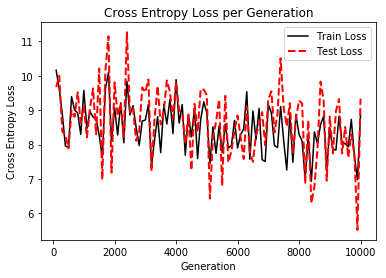

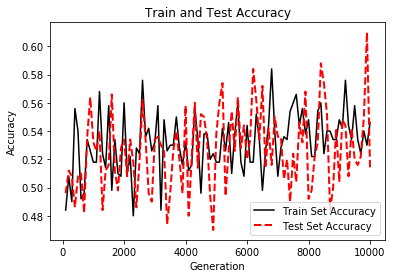

In [100]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=2)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=2)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()